In [1]:
# Connect to my google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# extract images
from zipfile import ZipFile
file_name =  "/content/gdrive/MyDrive/self driving car/drivable area/dataset/bdd100k_images.zip"

with ZipFile(file_name, "r") as m:
    m.extractall()
    print("Done")

Done


In [3]:
# extract segmentation images
from zipfile import ZipFile
file_name =  "/content/gdrive/MyDrive/self driving car/drivable area/dataset/bdd100k_drivable_maps.zip"

with ZipFile(file_name, "r") as m:
    m.extractall()
    print("Done")

Done


In [4]:
!mkdir train

In [5]:
%cd train/
!mkdir original_images
!mkdir masked_images

/content/train


In [6]:
%cd original_images/
!mkdir original

/content/train/original_images


In [7]:
%cd ../
%cd masked_images
!mkdir masked

/content/train
/content/train/masked_images


In [8]:
%cd ../../
!ls

/content
bdd100k  gdrive  sample_data  train


In [9]:
!mkdir validation

In [10]:
%cd validation/
!mkdir original_images
!mkdir masked_images

/content/validation


In [11]:
%cd original_images/
!mkdir original
%cd ../
%cd masked_images
!mkdir masked
%cd ../../
!ls

/content/validation/original_images
/content/validation
/content/validation/masked_images
/content
bdd100k  gdrive  sample_data  train  validation


In [12]:
!mkdir test

In [13]:
%cd test/
!mkdir original_images
!mkdir masked_images

/content/test


In [14]:
%cd ../
!ls

/content
bdd100k  gdrive  sample_data  test  train  validation


In [15]:
import os
from tqdm import tqdm


!mv "/content/bdd100k/images/100k/train" "/content/train/original_images/original"
!mv "/content/bdd100k/images/100k/val" "/content/validation/original_images/original"
!mv "/content/bdd100k/drivable_maps/color_labels/train" "/content/train/masked_images/masked"
!mv "/content/bdd100k/drivable_maps/color_labels/val" "/content/validation/masked_images/masked"

In [16]:
train_original_dir = "/content/train/original_images/original/train"
val_original_dir = "/content/validation/original_images/original/val"
train_masks_dir = "/content/train/masked_images/masked/train"
val_masks_dir = "/content/validation/masked_images/masked/val"

In [17]:
test_original_dir = "/content/test/original_images"
test_masks_dir = "/content/test/masked_images"


In [18]:
import os

for i,img in enumerate(os.listdir(train_original_dir)):
    if i<2000:
        path = os.path.join(train_original_dir, img)
        !mv {path} {test_original_dir}
        path = os.path.join(train_masks_dir, img.replace('.jpg', '_drivable_color.png'))
        !mv {path} {test_masks_dir}
    if i==2000:
        break


In [19]:
l = os.listdir(test_original_dir)
print(len(l))

2000


In [20]:
#stop

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def train_generator(img_dir, label_dir, batch_size, input_size):
    list_images = os.listdir(img_dir)
    shuffle(list_images) #Randomize the choice of batches
    ids_train_split = range(len(list_images))
    while True:
         for start in range(0, len(ids_train_split), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(ids_train_split))
            ids_train_batch = ids_train_split[start:end]
            for id in ids_train_batch:
                img = cv2.imread(os.path.join(img_dir, list_images[id]))
                img = cv2.resize(img, (input_size[0], input_size[1]))
                mask = cv2.imread(os.path.join(label_dir, list_images[id].replace('.jpg', '_drivable_color.png')), 0)
                mask = cv2.resize(mask, (input_size[0], input_size[1]))
                mask = (mask>0)
                mask = np.expand_dims(mask, axis=2)
                x_batch.append(img)
                y_batch.append(mask)

            x_batch = np.array(x_batch, np.float32) / 255
            y_batch = np.array(y_batch, np.float32) / 255

            yield x_batch, y_batch


In [22]:
!pip install segmentation-models

     |████████████████████████████████| 50 kB 6.2 MB/s 


In [23]:
import keras.utils.generic_utils
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score


Segmentation Models: using `keras` framework.


In [24]:
import tensorflow as tf

IMAGE_HEIGHT, IMAGE_WIDTH = 128,128

#Build the model
inputs = tf.keras.layers.Input((IMAGE_HEIGHT, IMAGE_WIDTH, 3))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(3, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss=bce_jaccard_loss, metrics=[iou_score])
model.summary()



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [25]:
# early stopping
from keras.callbacks import  EarlyStopping
from keras.callbacks import ModelCheckpoint

es = EarlyStopping(monitor='val_iou_score', mode='max', verbose=1, patience=2)
checkpoint = ModelCheckpoint("/content/gdrive/MyDrive/self driving car/drivable area/withou2kimages.h5", monitor='loss', verbose=1,
                            save_best_only=True, mode='auto', period=1)

from random import shuffle 
batch_size_val = 16
epoch_val = 15
history = model.fit_generator(train_generator(train_original_dir, train_masks_dir,batch_size_val,(128,128)),                                                                                      
                                steps_per_epoch= 70000 / batch_size_val,
                                epochs = epoch_val,
                                validation_data= train_generator(val_original_dir,val_masks_dir,batch_size_val,(128,128)),
                                validation_steps = 10000 / batch_size_val,
                                verbose= 1,
                                shuffle=1,
                                callbacks=[es,checkpoint]
                              ) 

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
4375/4375 [==============================] - 1966s 442ms/step - loss: 1.0054 - iou_score: 0.0018 - val_loss: 1.0029 - val_iou_score: 0.0022

Epoch 00001: loss improved from inf to 1.00538, saving model to /content/gdrive/MyDrive/self driving car/drivable area/withou2kimages.h5
Epoch 2/15
4375/4375 [==============================] - 1921s 439ms/step - loss: 1.0029 - iou_score: 0.0022 - val_loss: 1.0028 - val_iou_score: 0.0023

Epoch 00002: loss improved from 1.00538 to 1.00287, saving model to /content/gdrive/MyDrive/self driving car/drivable area/withou2kimages.h5
Epoch 3/15
4375/4375 [==============================] - 1954s 447ms/step - loss: 1.0027 - iou_score: 0.0023 - val_loss: 1.0026 - val_iou_score: 0.0025

Epoch 00003: loss improved from 1.00287 to 1.00271, saving model to /content/gdrive/MyDrive/self driving car/drivable area/withou2kimages.h5
Epoch 4/15
4375/4375 [==============================] - 1766s 404ms/step - loss: 1.0026 - iou_score: 0.0024 - val_loss: 1.002

In [26]:
imgg = cv2.imread("/content/validation/masked_images/masked/val/b1c66a42-6f7d68ca_drivable_color.png")
print(imgg.shape)

(720, 1280, 3)


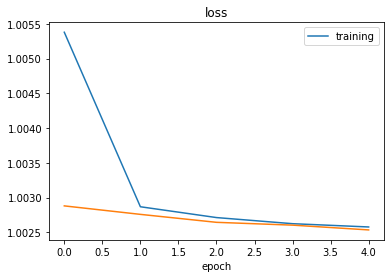

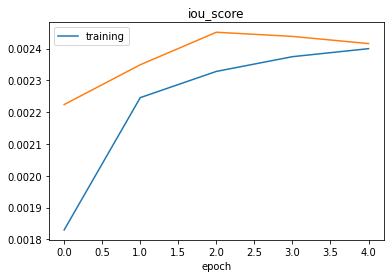

In [27]:
# PLOT

plt.figure(1)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(['training'])
plt.title('loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history["iou_score"])
plt.plot(history.history["val_iou_score"])
plt.legend(['training'])
plt.title('iou_score')
plt.xlabel('epoch')
plt.show()

In [28]:
stop

NameError: ignored

In [ ]:
# ελεγχοs

In [29]:
# Load my model
from keras.models import load_model
new_model_new = load_model("/content/gdrive/MyDrive/self driving car/drivable area/withou2kimages.h5",compile=False)
new_model_new.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [56]:
import os



pred = []
true = []
images= []

original_images_dir = "/content/test/original_images" 
masked_images_dir = "/content/test/masked_images" 


for file in tqdm(os.listdir(original_images_dir)):

    
    # take paths for original and mask images
    path1 = os.path.join(original_images_dir,file)
    curVar = file.rsplit(".")
    path2 = f"{masked_images_dir}/{curVar[0]}_drivable_color.png"
    
    # take predicted image
    img = np.zeros((1, IMAGE_HEIGHT, IMAGE_WIDTH, 3), dtype=np.float32)
    curIm = np.array(cv2.imread(path1))
    curIm = cv2.resize(curIm, (IMAGE_WIDTH,IMAGE_HEIGHT))
    img[0] = curIm  / 255 # Normalize to 0-1
    prd_img = new_model_new.predict(img)

    # take mask image
    true_image = np.array(cv2.imread(path2,cv2.IMREAD_GRAYSCALE))
    true_image = cv2.resize(true_image, (IMAGE_WIDTH,IMAGE_HEIGHT))
        
        
    prd_img = cv2.cvtColor(prd_img[0], cv2.COLOR_BGR2GRAY)
        
    #ayto an thes gia na tis vlepeis
    images.append(curIm)
    
    true.append(true_image)
    pred.append(prd_img)

100%|██████████| 2000/2000 [02:49<00:00, 11.83it/s]


In [57]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

total_precision = 0
total_recall = 0
total_f1 = 0

number_of_test_images = len(pred)

for count, predicted_image in enumerate(pred):
    true[count] = (true[count] > 0 )
    pred[count] = (pred[count] > 0.001)

    precision = precision_score(true[count], pred[count], pos_label='positive',average='micro')
    recall = recall_score(true[count], pred[count], pos_label='positive',average='micro')
    f1 = f1_score(true[count], pred[count], pos_label='positive',average='micro')
    total_precision = total_precision + precision
    total_recall = total_recall + recall
    total_f1 = total_f1 + f1

average_precision = total_precision / number_of_test_images
average_recall = total_recall / number_of_test_images
average_f1 = total_f1 / number_of_test_images

print(average_precision)
print(average_recall)
print(average_f1)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being s

0.8036105211481552
0.8430065307435737
0.8110077050730975


In [59]:
print("Average Precision:", average_precision)
print("Average Reccall:",average_recall)
print("Average f1 score:",average_f1)

Average Precision: 0.8036105211481552
Average Reccall: 0.8430065307435737
Average f1 score: 0.8110077050730975


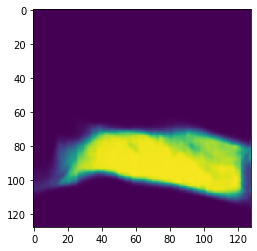

In [50]:
# gia na dw poio einai to kalutero > pou prepei na valw...einai to 0.001
c = 210
plt.imshow(pred[c])


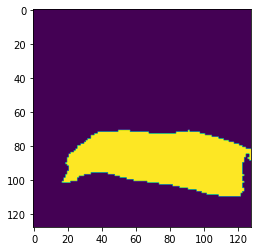

In [51]:
pred[c] = (pred[c] > 0.001)
plt.imshow(pred[c])

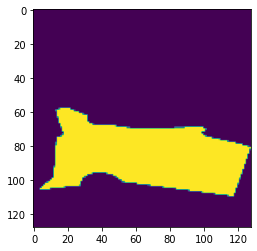

In [52]:
plt.imshow(true[c])

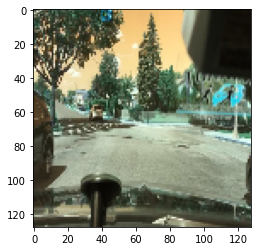

In [53]:
plt.imshow(images[c])